In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchtext

# Import matplotlib for visualization
import matplotlib.pyplot as plt

import random

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchtext version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchtext version: {torchtext.__version__}")

PyTorch version: 2.1.2
torchtext version: 0.16.2


In [2]:
device = "mps" if torch.backends.mps.is_available() \
    else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data

In [3]:
import pandas as pd

raw_df = pd.read_csv("/kaggle/input/machine-translation-dataset-de-en/translation_train.csv")
raw_df.sample(5)

,english,german
8276,An Elton John looking fella playing an instrum...,"Jemand, der aussieht wie Elton John, spielt ei..."
6000,The young football player is trying to avoid b...,"Der junge Football-Spieler versucht, einen Ang..."
9067,A man on the subway holds his bags and looks a...,Ein Mann in der U-Bahn hält seine Tüten und sc...
26233,A young woman playing guitar and singing on a ...,Eine junge Frau spielt auf einer Bühne Gitarre...
25955,A performer is jumping off the stage into a cr...,Ein Künstler springt von der Bühne in eine Fan...


In [4]:
raw_df['english'][8550], raw_df['german'][8550]

('Man with helmet performing a trick while rollerblading.',
 'Mann mit Helm vollführt ein Kunststück auf Rollerblades.')

## Tokenization

In [5]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 60.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
from torchtext.data.utils import get_tokenizer

en_tokenizer = get_tokenizer(tokenizer = 'spacy', language = "en_core_web_sm")
de_tokenizer = get_tokenizer(tokenizer = 'spacy', language = "de_core_news_sm")

# apply tokenizer to our dataset
tokenized_en_df = raw_df['english'].map(en_tokenizer)
tokenized_de_df = raw_df['german'].map(de_tokenizer)

# Create vocab

In [7]:
from torchtext.vocab import build_vocab_from_iterator

en_vocab = build_vocab_from_iterator(
    tokenized_en_df,
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True,
)
en_vocab.set_default_index(en_vocab['<unk>'])

de_vocab = build_vocab_from_iterator(
    tokenized_de_df,
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True,
)
de_vocab.set_default_index(de_vocab['<unk>'])

In [8]:
print(f"length of english vocabulary: {len(en_vocab)}")
print(f"length of german vocabulary: {len(de_vocab)}")

length of english vocabulary: 6191
length of german vocabulary: 8014


In [9]:
from torchtext import transforms

en_transform = transforms.Sequential(
    ## converts the sentences to indices based on given vocabulary
    transforms.VocabTransform(vocab=en_vocab),

    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is 1 as seen in previous section
    transforms.AddToken(en_vocab['<sos>'], begin=True),

    ## Add <eos> at end of each sentence. 2 because the index for <eos> in vocabulary is 2 as seen in previous section
    transforms.AddToken(en_vocab['<eos>'], begin=False),
    
    ## converts data into tensor
    transforms.ToTensor(),
    
#     ## padding
#     transforms.PadTransform(
#         max_length = tokenized_en_df.map(len).max() + 2, #2 for <sos> and <eos>
#         pad_value = 0)
    )

In [10]:
from torchtext import transforms

de_transform = transforms.Sequential(
    ## converts the sentences to indices based on given vocabulary
    transforms.VocabTransform(vocab=de_vocab),

    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is 1 as seen in previous section
    transforms.AddToken(de_vocab['<sos>'], begin=True),
    
    ## converts data into tensor
    transforms.ToTensor(),
    
#     ## padding
#     transforms.PadTransform(
#         max_length = tokenized_de_df.map(len).max() + 1, #1 for <sos> 
#         pad_value = 0)
    )

In [11]:
from torchtext import transforms

label_transform = transforms.Sequential(
    ## converts the sentences to indices based on given vocabulary
    transforms.VocabTransform(vocab=de_vocab),

    ## Add <eos> at end of each sentence. 2 because the index for <eos> in vocabulary is 2 as seen in previous section
    transforms.AddToken(de_vocab['<eos>'], begin=False),
    
    ## converts data into tensor
    transforms.ToTensor(),
    
#     ## padding
#     transforms.PadTransform(
#         max_length = tokenized_de_df.map(len).max() + 1, #1 for <sos> 
#         pad_value = 0)
    )

## Make a dataset

In [12]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset


# 1. Subclass torch.utils.data.Dataset
class Translation_DatasetCustom(Dataset):
    
    # 2. Initialize with a target_dir and transform (optional) parameter
    def __init__(self, df, transform, 
                 en_lang, en_tokenizer,
                 de_lang = None, de_tokenizer=None, 
                 is_labeled = True):
        
        if is_labeled == True:
            assert de_lang != None
            assert de_tokenizer != None
            assert de_lang in transform
        
        
            
    # 3. Create class attributes
        self.df = df
        
        self.en_tokenizer = en_tokenizer  # encoder_tokenizer
        self.de_tokenizer = de_tokenizer  # decoder_tokenizer
        
        self.en_lang = en_lang # encoder_language
        self.de_lang = de_lang # decoder_language
        
        self.transform = transform
        
        self.is_labeled = is_labeled
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.df)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        if self.is_labeled == True:
            tokenized_en_text = self.en_tokenizer(self.df[self.en_lang].values[index])
            tokenized_de_text = self.de_tokenizer(self.df[self.de_lang].values[index])
            transformed_en_text = self.transform[self.en_lang](tokenized_en_text)
            transformed_de_text = self.transform[self.de_lang](tokenized_de_text)
            transformed_label = self.transform['label'](tokenized_de_text)
            return transformed_en_text, transformed_de_text, transformed_label # return data, label (X, y)
        else:
            tokenized_en_text = en_tokenizer(self.df[self.en_lang].values[index])
            transformed_en_text = self.transform[self.en_lang](tokenized_en_text)
            return transformed_en_text

In [13]:
En_De_Dataset = Translation_DatasetCustom(
    df = raw_df,
    en_lang = "english",
    de_lang = "german",
    en_tokenizer = en_tokenizer,
    de_tokenizer = de_tokenizer,
    transform = {'english': en_transform, 
                 'german': de_transform,
                 'label': label_transform},
    is_labeled = True
)

In [14]:
En_De_Dataset[1]

(tensor([   1,  165,   36,    7,  335,  287,   17, 1224,    4,  758, 4496, 2957,
            5,    2]),
 tensor([   1,   84,   31,   10,  847, 2208,   15,    3,    4]),
 tensor([  84,   31,   10,  847, 2208,   15,    3,    4,    2]))

## Split dataset into train and validate

In [15]:
from torch.utils.data import Dataset, DataLoader, random_split

# Define the sizes of the splits
train_size = int(0.8 * len(En_De_Dataset))
val_size = len(En_De_Dataset) - train_size

# Use random_split to split the dataset
train_dataset, val_dataset = random_split(En_De_Dataset, [train_size, val_size])

## Prepare dataloader

In [16]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Separate data and labels
    en_sequences, de_sequences, labels = zip(*batch)
    # Pad the sequences
    padded_en_sequences = pad_sequence(en_sequences, batch_first=True, padding_value=0)
    padded_de_sequences = pad_sequence(de_sequences, batch_first=True, padding_value=0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=0)

    
    return padded_en_sequences, padded_de_sequences, padded_labels

In [17]:
from torch.utils.data import DataLoader
import os

# Setup the batch size hyperparameter
BATCH_SIZE = 512
NUM_CORES = os.cpu_count()

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True, # shuffle data every epoch?
    num_workers = NUM_CORES,
    pin_memory =True,
    collate_fn=collate_fn
    
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False, # don't necessarily have to shuffle the testing data
    num_workers = NUM_CORES,
    pin_memory =True,
    collate_fn=collate_fn
                            
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, val_dataloader}") 
print(f"Length of training dataset: {len(train_dataloader.dataset)}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataset: {len(val_dataloader.dataset)}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x788f5eb1cc10>, <torch.utils.data.dataloader.DataLoader object at 0x788f5eb1e590>)
Length of training dataset: 23200
Length of train dataloader: 46 batches of 512
Length of val dataset: 5800
Length of val dataloader: 5800 batches of 512


In [18]:
input_sequences_batch, output_sequences_batch, labels_batch = next(iter(train_dataloader))
input_sequences_batch.shape, output_sequences_batch.shape, labels_batch.shape

(torch.Size([512, 31]), torch.Size([512, 29]), torch.Size([512, 29]))

In [19]:
input_sequences_batch, output_sequences_batch, labels_batch = next(iter(val_dataloader))
input_sequences_batch.shape, output_sequences_batch.shape, labels_batch.shape

(torch.Size([1, 21]), torch.Size([1, 19]), torch.Size([1, 19]))

# Model

In [20]:
class Encoder_Simple_Seq2Seq (torch.nn.Module):
    def __init__(self, vocab, embedding_size, hidden_state_size):
        super().__init__()
        
        self.embedding = torch.nn.Embedding(
            num_embeddings = len(vocab), 
            embedding_dim = embedding_size, 
            padding_idx = vocab['<pad>']
        )
        
        self.gru = torch.nn.GRU(
            input_size = embedding_size,
            hidden_size = hidden_state_size,
            batch_first = True,
            bias = True
        )
    
    def forward(self, encoder_input):
        # encoder_input_shape = [N,seq_en]
        
        out = self.embedding(encoder_input)
        out = torch.relu(out)
        # output_embedding_shape = [N,seq_en,embedding_size]
        
        out, hn = self.gru(out)
        # output_gru_shape = [N,seq_en,hidden_size]; hidden_gru_shape = [1,N,hidden_size]
        
        return out, hn

In [21]:
class Decoder_Simple_Seq2Seq (torch.nn.Module):
    def __init__(self, vocab, embedding_size, hidden_state_size):
        super().__init__()
        
        self.embedding = torch.nn.Embedding(
            num_embeddings = len(vocab), 
            embedding_dim = embedding_size, 
            padding_idx = vocab['<pad>']
        )
        
        self.gru = torch.nn.GRU(
            input_size = embedding_size,
            hidden_size = hidden_state_size,
            batch_first = True,
            bias = True
        )
                
    def forward(self, decoder_hidden, decoder_input = None):
        # decoder_input_shape = [N,seq_de]
        # decoder_hidden = [1,N,hidden_size]
        
        out = self.embedding(decoder_input)
        out = torch.relu(out)
        # output_embedding_shape = [N,seq_de,embedding_size]
        
        out, hn = self.gru(
            out, # input
            decoder_hidden # h_0
        )
        # output_gru_shape = [N,seq_de,hidden_size]; hidden_gru_shape = [1,N,hidden_size]
        
        return out, hn

In [22]:
class Simple_Seq2Seq(torch.nn.Module):
    def __init__(self, 
                 embedding_size, 
                 hidden_state_size, 
                 output_size, 
                 encoder_vocab, decoder_vocab,
                 encoder = None, decoder = None, 
                 max_length = 5000):
        
        super().__init__()
        
        self.max_length = max_length
        self.encoder_vocab = encoder_vocab
        self.decoder_vocab = decoder_vocab
        
        # The core of model
        if encoder != None:
            self.encoder = encoder
        else:
            self.encoder = Encoder_Simple_Seq2Seq(
                                vocab = encoder_vocab, 
                                embedding_size = embedding_size, 
                                hidden_state_size = hidden_state_size
                            )
            
        if decoder != None:
            self.decoder = decoder
        else:
            self.decoder = Decoder_Simple_Seq2Seq(
                                vocab = decoder_vocab, 
                                embedding_size = embedding_size, 
                                hidden_state_size = hidden_state_size
                            )
        # The classifier
        
        self.classifier = torch.nn.Sequential(
            torch.nn.LayerNorm(hidden_state_size),
            torch.nn.Linear(hidden_state_size, hidden_state_size),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(hidden_state_size),
            torch.nn.Linear(hidden_state_size, output_size),
            torch.nn.LayerNorm(output_size)
        )
        
        
        
    def do_training(self, encoder_input, decoder_input, epoch):
        # encoder_input_shape = [N,seq_en], decoder_input_shape = [N,seq_de]
        
        encoder_output, encoder_hidden = self.encoder(encoder_input)
        # encoder_output_shape = [N,seq_en,hidden_size]; encoder_hidden_shape = [1,N,hidden_size]
        
        decoder_hidden = encoder_hidden
        # decoder_hidden_shape = [1,N,hidden_size]
        
        decoder_output = []
        
        # Teacher Forcing
        for i in range(decoder_input.shape[1]):
            
            if i > 0:
                if epoch >= 200:
                    if torch.rand(1) < 0.5:
                        inputs = torch.multinomial(torch.softmax(outputs.squeeze(1), dim=1), 
                                                   num_samples=1, replacement=True)
                        # input_shapes = [N,1]

            inputs = decoder_input[:,i].unsqueeze(1)
            # decoder_input[:,i]_shape = [N]; input_shape = [N,1]

            outputs, decoder_hidden  = self.decoder(decoder_hidden, inputs)
            # outputs_shape = [N,1,hidden_size], decoder_hidden_shape = [1,N,hidden_size]

            outputs = self.classifier(outputs)
            # output_linear_shape = [N,1,vocab_size]

            decoder_output.append(outputs)
            # decoder_output_shape = (seq_de * [N,1,vocab_size])
                
        decoder_output = torch.cat(decoder_output, dim = 1)
        # decoder_output_shape = [N,seq_de,vocab_size]
    
        return decoder_output
    
    def make_generation(self, encoder_input, search_strategy = 'beam_search', beam_size = 7):
        """
            Batch_size must be one 
        """
        assert encoder_input.shape[0] == 1, "batch_size != 1"
        
        if search_strategy == 'beam_search':
            generated_sequence = self.Beam_Search(beam_size, encoder_input)
        else:
            generated_sequence = self.Greedy_Search(encoder_input)
        
        return generated_sequence

In [23]:
def Greedy_step(self, output_at_t):
    # output_at_t = [N,1,vocab_size]
    
    top_prob, top_idx = output_at_t.topk(1, dim = 2) 
    # top_idx_shape = [N,1,1]

    top_idx = top_idx.squeeze(1).detach()
    # top_idx_shape = [N,1]

    return top_idx

def Greedy_Search(self, encoder_input):
    # encoder_input_shape = [N,seq_en]
    
    encoder_output, encoder_hidden = self.encoder(encoder_input)
    # encoder_output_shape = [N,seq_en,hidden_size]; encoder_hidden_shape = [1,N,hidden_size]
        
    decoder_hidden = encoder_hidden
    # decoder_hidden_shape = [1,N,hidden_size]
    
    
    batch_size = encoder_input.shape[0]
    inputs = torch.ones(
        size = (batch_size, 1),
        dtype = torch.long,
        device = device if device == 'cuda' else 'cpu'
    ) * self.decoder_vocab['<sos>']
    # input_shape = [N,1]

    
    generated_sequence = [inputs]
    for i in range(self.max_length):
        outputs, decoder_hidden  = self.decoder(decoder_hidden, inputs)
        # outputs_shape = [N,1,hidden_size], decoder_hidden_shape = [1,N,hidden_size]

        outputs = self.classifier(outputs)
        # output_linear_shape = [N,1,vocab_size]

        inputs = self.Greedy_step(torch.softmax(outputs,dim=2))
        # inputs_shape = [N,1]
        
        generated_sequence.append(inputs)

        if inputs.item() == self.decoder_vocab['<eos>']:
            break
        
    generated_sequence = torch.cat(generated_sequence, dim = 1)
    # generated_sequence_shape = [N,seq_de]
        
    return generated_sequence.squeeze(0)

Simple_Seq2Seq.Greedy_step = Greedy_step
Simple_Seq2Seq.Greedy_Search = Greedy_Search

In [24]:
def Beam_step(self, beam_size, output_at_t):
    # output_at_t = [N,1,vocab_size]
    
    top_prob, top_idx = output_at_t.topk(beam_size, dim = 2) 
    # top_idx_shape = [N,1,beam_size]
    # top_prob_shape = [N,1,beam_size]

    top_idx = top_idx.squeeze(1).detach()
    # top_idx_shape = [N,beam_size]

    top_prob = top_prob.squeeze(1).detach()
    # top_prob_shape = [N,beam_size]
    
    return top_idx, top_prob

def Beam_Search(self, beam_size, encoder_input):
    # encoder_input_shape = [N,seq_en]

    encoder_output, encoder_hidden = self.encoder(encoder_input)
    # encoder_output_shape = [N,seq_en,hidden_size]; encoder_hidden_shape = [1,N,hidden_size]

    batch_size = encoder_input.shape[0]
    inputs = torch.ones(
        size = (batch_size, 1),
        dtype = torch.long,
        device = device if device == 'cuda' else 'cpu'
    ) * self.decoder_vocab['<sos>']
    # input_shape = [N,1]

    candidate_sequence = inputs
    # candidate_sequence_shape = [N,1]
    
    score = torch.log(torch.ones(size = [batch_size, 1], 
                                device = device if device == 'cuda' else 'cpu'))
    # score_shape = [N,1]
    
    candidates = [(candidate_sequence, score, encoder_hidden)]
    
    finished_candidates = []
    for i in range(self.max_length):
        
        new_candidates = []
        for candidate_sequence, score, decoder_hidden in candidates:
            # candidates_shape = beam_size * ()
            # candidate_sequence_shape = [N,seq]
            # score_shape = [N,1]
            # decoder_hidden_shape = [1,N,hidden_size]

            inputs = candidate_sequence[:,-1].unsqueeze(-1)
            # inputs_shape = [N,1]
            
            if inputs.item() == self.decoder_vocab['<eos>']:
                finished_candidates.append((candidate_sequence, score, decoder_hidden))
                continue
            
            outputs, decoder_hidden  = self.decoder(decoder_hidden, inputs)
            # outputs_shape = [N,1,hidden_size], decoder_hidden_shape = [1,N,hidden_size]
            
            outputs = self.classifier(outputs)
            # output_linear_shape = [N,1,vocab_size]

            top_tokens, top_probs = self.Beam_step(beam_size = beam_size, 
                                                   output_at_t = torch.softmax(outputs,dim=2))
            # top_tokens = [N,beam_size]
            # top_probs = [N,beam_size]
            
            for j in range(beam_size):
                new_candidate_sequence = torch.cat([candidate_sequence, top_tokens[:,j].unsqueeze(-1)], dim = 1) # top_tokens[:,j].unsqueeze(-1) -> shape: [N,1]
                # new_candidate_sequence_shape = [N,seq+1]
                new_score = score + torch.log(top_probs[:,j].unsqueeze(-1))  # top_probs[:,j].unsqueeze(-1) -> shape: [N,1]
                # new_score_shape = [N,1]
                new_candidates.append((new_candidate_sequence, new_score, decoder_hidden))
            
        
            new_candiadates = sorted(new_candidates, key=lambda x: x[1]/len(x[0]), reverse=True)
            candidates = new_candidates[:beam_size]
        
        
        if all([candidate_sequence[:,-1].unsqueeze(-1) == self.decoder_vocab['<eos>'] \
                for candidate_sequence, _, _ in candidates]):
            break
        
        if len(finished_candidates) == beam_size/2:
            break
            
        
            
    candidates.extend(finished_candidates)
    candidates = sorted(candidates, key=lambda x: x[1]/len(x[0]), reverse=True)
        
    return candidates[0][0].squeeze(0)

Simple_Seq2Seq.Beam_step = Beam_step
Simple_Seq2Seq.Beam_Search = Beam_Search

In [25]:
def convert_to_sentence(sequence, vocab):

    try:
        sos_idx = list(sequence).index(vocab['<sos>'])
    except ValueError as Error:
        sos_idx = -1
    
    try:
        eos_idx = list(sequence).index(vocab['<eos>'])
    except ValueError as Error:
        eos_idx = -1
        
    if eos_idx != -1:
        sequence = vocab.lookup_tokens(list(sequence)[sos_idx+1: eos_idx])
    else:
        sequence = vocab.lookup_tokens(list(sequence)[sos_idx+1:])
        
    sentences = ' '.join(sequence)
    
    return sentences

In [26]:
model_0 = Simple_Seq2Seq(
    embedding_size = 512,
    hidden_state_size = 512, 
    output_size = len(de_vocab),
    encoder_vocab = en_vocab,
    decoder_vocab = de_vocab,
    max_length = 50
)
model_0.to(device)

Simple_Seq2Seq(
  (encoder_vocab): Vocab()
  (decoder_vocab): Vocab()
  (encoder): Encoder_Simple_Seq2Seq(
    (embedding): Embedding(6191, 512, padding_idx=0)
    (gru): GRU(512, 512, batch_first=True)
  )
  (decoder): Decoder_Simple_Seq2Seq(
    (embedding): Embedding(8014, 512, padding_idx=0)
    (gru): GRU(512, 512, batch_first=True)
  )
  (classifier): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=512, out_features=8014, bias=True)
    (5): LayerNorm((8014,), eps=1e-05, elementwise_affine=True)
  )
)

In [27]:
sample = input_sequences_batch[0].unsqueeze(0)

In [28]:
sequence = model_0.make_generation(sample.to(device))
sequence

tensor([   1, 1155, 1440, 2478, 1440,  496, 5935, 3097, 2478, 1215, 1090, 4390,
        1031, 1090, 4390, 1031, 1090, 4390, 1031, 1090, 6101, 5762, 5722, 6213,
        6567, 1440, 2541, 2707, 6703, 3954, 3504, 7405, 6978, 4029, 5092, 5092,
        6461, 6660, 2131, 1064, 6978, 2205, 5092, 5092, 6461, 6660, 2131, 1064,
        6978, 2205, 5092], device='cuda:0')

In [29]:
sentence = convert_to_sentence(sequence, de_vocab)
sentence

'Kleiner dunkelhaariger probiert dunkelhaariger fest Friseurstuhl nacktes probiert Steinmauer Teleskop Beagle bringt Teleskop Beagle bringt Teleskop Beagle bringt Teleskop Holzklötzen Cola Burger Knöpfe Rennmotorrad dunkelhaariger Cheerleadern etwa Segel Seile gesteckt gart Unterführung Unterhaltung beeindruckende beeindruckende Paintball Schnüren Frisur bunte Unterführung ausgestreckt beeindruckende beeindruckende Paintball Schnüren Frisur bunte Unterführung ausgestreckt beeindruckende'

# Train

In [30]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [31]:
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler,
               epoch,
               device: torch.device = 'cpu'):
    
    if device != 'cpu':
        model.to(device)
    
    train_loss = 0
    model.train()
    
    Learning_rate = []
    for batch, (X_encoder,X_decoder, y) in enumerate(data_loader):
        # Send data to GPU
        if device != 'cpu':
            X_encoder, X_decoder, y = X_encoder.to(device), X_decoder.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model.do_training(X_encoder, X_decoder, epoch)
            # y_pred_shape = [N,seq_de,vocab_size]
        
        # 2. Calculate loss
        loss = loss_fn(y_pred.view(-1,y_pred.shape[2]), y.view(-1))
        train_loss += loss
				
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        # 6. Scheduler step
        scheduler.step()
        
        # Log the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        Learning_rate.append(current_lr)
    

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)

    return train_loss, Learning_rate


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              device: torch.device = 'cpu'):
    
    if device != 'cpu':
        model.to(device)

    model.eval() 
    
    with torch.inference_mode(): 
        
        X_encoder,X_decoder, y = list(data_loader)[7]
        
        # Send data to GPU
        if device != 'cpu':
            X_encoder, X_decoder, y = X_encoder.to(device), X_decoder.to(device), y.to(device)

        sequence = model.make_generation(X_encoder)

        # print translation results
        Generated_sentence = convert_to_sentence(sequence.cpu(), model.decoder_vocab)
        Input_sentence = convert_to_sentence(X_encoder.squeeze(0).cpu(), model.encoder_vocab)
        Label_sentence = convert_to_sentence(y.squeeze(0).cpu(), model.decoder_vocab)

    return Input_sentence, Label_sentence, Generated_sentence

In [33]:
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device = 'cpu') -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {
        "Training_Loss": [],
        "Learning_rate": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
            Training_Loss, Learning_rate = train_step(
                data_loader=train_dataloader, 
                model=model, 
                loss_fn=loss_fn,
                optimizer=optimizer,
                scheduler = scheduler,
                epoch=epoch,
                device=device
            )
            Translation_results = test_step(
                data_loader=test_dataloader,
                model=model,
                device=device
            )
            # Print out what's happening
            print(
                f"Epoch: {epoch} | Training_Loss: {Training_Loss:.4f} | Learning rate mean: {torch.tensor(Learning_rate).mean()} \n"
                f"Input_sentence: {Translation_results[0]}\n"
                f"Output_sentence: {Translation_results[1]}\n"
                f"Generated_sentence: {Translation_results[2]}\n"
            )

            # Update results dictionary
            results["Training_Loss"].append(Training_Loss.item())
            results["Learning_rate"].extend(Learning_rate)

  # Return the filled results at the end of the epochs
    return results

In [34]:
def plot_results(Training_Loss):
    plt.figure(figsize=(10,5))
    
    plt.plot(Training_Loss, color="blue", label="Training Loss")
    plt.title("Training and Test Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=model_0.decoder_vocab['<pad>']) 

initial_lr = 0.001
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=initial_lr)

max_lr = 0.1
steps_per_epoch = len(train_dataloader) # the number of batch per epoch
epochs = 300 # NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs)

In [36]:
from tqdm.auto import tqdm

set_seeds()

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

# Setup the num_epochs hyperparameter
NUM_EPOCHS = epochs

results = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler = scheduler,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device)

train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0 | Training_Loss: 5.0163 | Learning rate mean: 0.004010072443634272 
Input_sentence: An Ohio State team mascot performs on the field .
Output_sentence: Ein Maskottchen des Ohio State-Teams tritt auf dem Spielfeld auf .
Generated_sentence: Ein Mann in einem <unk> .

Epoch: 1 | Training_Loss: 4.0505 | Learning rate mean: 0.004069204442203045 
Input_sentence: An Ohio State team mascot performs on the field .
Output_sentence: Ein Maskottchen des Ohio State-Teams tritt auf dem Spielfeld auf .
Generated_sentence: Ein Mann in einem <unk> und <unk> und <unk> und ein Mann in einem <unk> und <unk> und <unk> , die auf einem <unk> .

Epoch: 2 | Training_Loss: 3.6621 | Learning rate mean: 0.004186761565506458 
Input_sentence: An Ohio State team mascot performs on the field .
Output_sentence: Ein Maskottchen des Ohio State-Teams tritt auf dem Spielfeld auf .
Generated_sentence: Ein Mann in einem schwarzen Hemd und einem schwarzen Hemd und einem schwarzen Hemd und einem schwarzen Hemd und ein

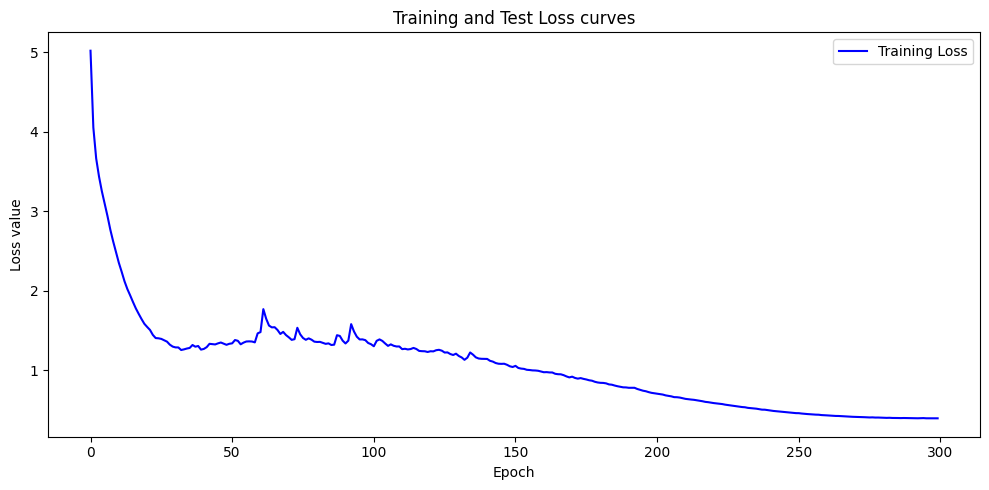

In [37]:
plot_results(results["Training_Loss"])

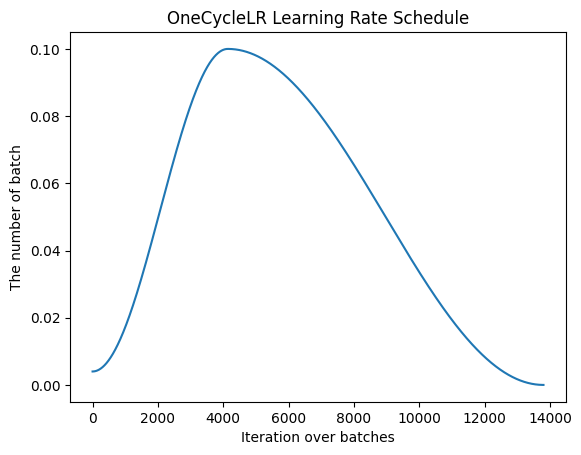

In [38]:
plt.plot(results["Learning_rate"])
plt.xlabel('Iteration over batches')
plt.ylabel('The number of batch')
plt.title('OneCycleLR Learning Rate Schedule')
plt.show()

In [39]:
from pathlib import Path
target_dir_path = Path("/kaggle/working/experiment")
target_dir_path.mkdir(parents=True,exist_ok=True)
model_name = 'simple_seq2seq.pt'
model_save_path = target_dir_path / model_name
torch.save(obj=model_0.state_dict(), f=model_save_path)

# Evaluation and Prediction

In [40]:
import pandas as pd

test_df = pd.read_csv("/kaggle/input/machine-translation-dataset-de-en/translation_test.csv")
test_df.head(5)

,english,german
0,A man in an orange hat starring at something.,"Ein Mann mit einem orangefarbenen Hut, der etw..."
1,A Boston Terrier is running on lush green gras...,Ein Boston Terrier läuft über saftig-grünes Gr...
2,A girl in karate uniform breaking a stick with...,Ein Mädchen in einem Karateanzug bricht einen ...
3,Five people wearing winter jackets and helmets...,Fünf Leute in Winterjacken und mit Helmen steh...
4,People are fixing the roof of a house.,Leute Reparieren das Dach eines Hauses.


In [41]:
from torchtext.data.utils import get_tokenizer

en_tokenizer = get_tokenizer(tokenizer = 'spacy', language = "en_core_web_sm")

# apply tokenizer to our dataset
tokenized_en_test_df = test_df['english'].map(en_tokenizer)
tokenized_en_test_df

0      [A, man, in, an, orange, hat, starring, at, so...
1      [A, Boston, Terrier, is, running, on, lush, gr...
2      [A, girl, in, karate, uniform, breaking, a, st...
3      [Five, people, wearing, winter, jackets, and, ...
4      [People, are, fixing, the, roof, of, a, house, .]
                             ...                        
995    [Marathon, runners, are, racing, on, a, city, ...
996    [Asian, woman, wearing, a, sunhat, while, ridi...
997    [Some, children, are, outside, playing, in, th...
998    [An, older, man, is, playing, a, video, arcade...
999    [A, girl, at, the, shore, of, a, beach, with, ...
Name: english, Length: 1000, dtype: object

In [42]:
Test_Dataset = Translation_DatasetCustom(
    df = test_df,
    en_lang = 'english',
    en_tokenizer = en_tokenizer,
    transform = {'english': en_transform},
    is_labeled = False
)

In [43]:
from torch.utils.data import DataLoader
import os

# Setup the batch size hyperparameter
BATCH_SIZE = 1
NUM_CORES = os.cpu_count()

# Turn datasets into iterables (batches)
test_dataloader = DataLoader(
    Test_Dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle = False,
    num_workers = NUM_CORES,
    pin_memory = True
    
)
# Let's check out what we've created
print(f"Dataloaders: {test_dataloader}") 
print(f"Length of training dataset: {len(test_dataloader.dataset)}")
print(f"Length of train dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x788f4544cd60>
Length of training dataset: 1000
Length of train dataloader: 1000 batches of 1


In [44]:
def Evaluate_and_Predict(model: torch.nn.Module,
                           data_loader: torch.utils.data.DataLoader,
                           metrics,
                           device: torch.device = 'cpu'):
    
    if device != 'cpu':
        model.to(device)

    model.eval() 
    
    score = {}
    y = []
    with torch.inference_mode():
        pbar = tqdm(enumerate(data_loader), total=len(data_loader), desc="Evaluating")
        for batch, X_encoder in pbar:
            
            # Send data to GPU
            if device != 'cpu':
                X_encoder= X_encoder.to(device)

            sequence = model.make_generation(X_encoder)
            Generated_sentence = convert_to_sentence(sequence.cpu(), model.decoder_vocab)            
            Label_sentence = test_dataloader.dataset.df['german'][batch]
            
            metrics['Cer'].update(Generated_sentence, Label_sentence)
            metrics['Wer'].update(Generated_sentence, Label_sentence)
            metrics['Bleu'].update([Generated_sentence], [[Label_sentence]])
            
            y.append(Generated_sentence)

        score['cer'] = [metrics['Cer'].compute().item()]
        score['wer'] = [metrics['Wer'].compute().item()]
        score['bleu'] = [metrics['Bleu'].compute().item()]
                        
    return pd.DataFrame(score), y

In [45]:
import torchmetrics
metrics = {'Cer': torchmetrics.text.CharErrorRate(), 
           'Wer': torchmetrics.text.WordErrorRate(), 
           'Bleu': torchmetrics.text.BLEUScore()}

In [46]:
score , predictions = Evaluate_and_Predict(model_0, test_dataloader, metrics, device)
score

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

,cer,wer,bleu
0,1.148659,1.611529,0.019758


In [47]:
test_df['generated'] = predictions

print(test_df['english'][7], test_df['german'][7], test_df['generated'][7], sep = '\n')
print()
print(test_df['english'][9], test_df['german'][9], test_df['generated'][9], sep = '\n')
print()
print(test_df['english'][12], test_df['german'][12], test_df['generated'][12], sep = '\n')

A boy in a red uniform is attempting to avoid getting out at home plate, while the catcher in the blue uniform is attempting to catch him.
Ein Junge in einem roten Trikot versucht, die Home Base zu erreichen, während der Catcher im blauen Trikot versucht, ihn zu fangen.
Ein Mann in Teenager laufen ein gelben <unk> um die <unk> um einen gelben Westen , im Hintergrund ein Foto von einem Spieler zu machen .

A man in a vest is sitting in a chair and holding magazines.
Ein Mann in einer Weste sitzt auf einem Stuhl und hält Magazine.
Ein Mann in einem beigen , sitzt eine blonde und rosafarbenen Jacke die Augen in einer grünen Jacke , mit einer Wand im Freien über das betrachtet .

A woman holding a bowl of food in a kitchen.
Eine Frau, die in einer Küche eine Schale mit Essen hält.
Eine schwarze Katze sitzt mit einem Baby und einem <unk> bei einem Mann .
